In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import Model
import os

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Preprocessing of the data**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      shear_range = 0.2, 
      zoom_range = 0.2, 
      height_shift_range = 0.2,
      width_shift_range = 0.2,
      horizontal_flip = True, 
      )

In [ ]:
# this is the augmentation configuration we will use for testing:
test_datagen = ImageDataGenerator(rescale=1. / 255)     # only rescaling

In [ ]:
# input image dimensions
img_rows, img_cols = 224, 224

train_data = train_datagen.flow_from_directory('/content/drive/MyDrive/Final Year Project/train', 
                                            target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

test_data = test_datagen.flow_from_directory('/content/drive/MyDrive/Final Year Project/test',
                                          target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

Found 1600 images belonging to 4 classes.
Found 439 images belonging to 4 classes.


In [ ]:
Y = train_data.class_indices
Y

{'Acne and Rosacea': 0,
 'Melanoma Skin Cancer Nevi and Moles': 1,
 'Psoriasis pictures Lichen Planus and related diseases': 2,
 'Vasculitis': 3}

## **Model Training**

In [ ]:
from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPool2D, BatchNormalization, Dropout
from keras.models import Sequential

model = Sequential()

Adding Convolutional and MaxPooling Layers

In [ ]:
model.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(100, (5,5), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(MaxPool2D(pool_size=(2,2)))

Add flattening layers

In [ ]:
model.add(Flatten())
model.add(Dense(124))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 100)     80100     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 100)    400       
 hNormalization)                                                 
                                                        

Fitting the data and compiling it

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 36.3043 - accuracy: 0.3681
Epoch 00001: val_loss improved from inf to 50.59056, saving model to cnn_model.h5
50/50 [==============================] - 479s 10s/step - loss: 36.3043 - accuracy: 0.3681 - val_loss: 50.5906 - val_accuracy: 0.2733 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 3.7305 - accuracy: 0.3400
Epoch 00002: val_loss did not improve from 50.59056
50/50 [==============================] - 431s 9s/step - loss: 3.7305 - accuracy: 0.3400 - val_loss: 110.7326 - val_accuracy: 0.2460 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 1.3371 - accuracy: 0.3300
Epoch 00003: val_loss did not improve from 50.59056
50/50 [==============================] - 436s 9s/step - loss: 1.3371 - accuracy: 0.3300 - val_loss: 150.6081 - val_accuracy: 0.2620 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 1.3439 - accuracy: 0.2912
E

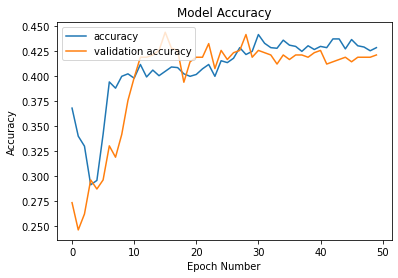

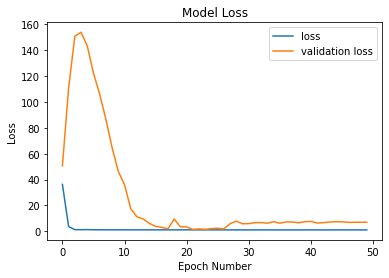

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# simple early stopping
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(patience=5, monitor="val_loss", mode="min")

model_chkpt = ModelCheckpoint('cnn_model.h5',
                              monitor='val_loss', verbose=1, mode="min",
                              save_best_only=True)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
h = model.fit_generator(train_data, epochs = 50, validation_data = test_data, callbacks=[lr_reducer, model_chkpt], verbose=1)
model.save('final_cnnmodel.h5')

# summarize history for accuracy
plt.plot(h.history['accuracy'],label='accuracy')
plt.plot(h.history['val_accuracy'],label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h.history['loss'],label='loss')
plt.plot(h.history['val_loss'],label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Load and evaluate the saved model

In [2]:
from keras.models import load_model
import cv2

In [12]:
model = load_model('/content/drive/MyDrive/Final Year Project/final_cnnmodel.h5', compile=True)
img = '/content/drive/MyDrive/Final Year Project/test/Acne and Rosacea /acne-pustular-20.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][0])

{'Acne and Rosacea': 1.0, 'Melanoma Skin Cancer Nevi and Moles': 0.0, 'Psoriasis pictures Lichen Planus and related diseases': 0.0, 'Vasculitis': 4.997678e-17}


In [13]:
img = '/content/drive/MyDrive/Final Year Project/test/Mela Test/malignant-melanoma-106.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][1])

{'Acne and Rosacea': 0.00069566496, 'Melanoma Skin Cancer Nevi and Moles': 0.853275, 'Psoriasis pictures Lichen Planus and related diseases': 0.0015183218, 'Vasculitis': 0.144511}


In [15]:
img = '/content/drive/MyDrive/Final Year Project/test/Psoriasis pictures Lichen Planus and related diseases/Psoriasis-Guttate-79.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][2])

{'Acne and Rosacea': 0.22885011, 'Melanoma Skin Cancer Nevi and Moles': 0.29449528, 'Psoriasis pictures Lichen Planus and related diseases': 0.1378091, 'Vasculitis': 0.32515693}


In [16]:
img = '/content/drive/MyDrive/Final Year Project/test/Vasculitis/erythema-multiforme-9.jpg'
img = cv2.resize(cv2.imread(img), (224,224)) / 255.0
prediction = model.predict(img.reshape(1,224,224,3))
d = {'Acne and Rosacea':0,'Melanoma Skin Cancer Nevi and Moles':0,'Psoriasis pictures Lichen Planus and related diseases':0,'Vasculitis': 0}
d['Acne and Rosacea'] = prediction[0][0]
d['Melanoma Skin Cancer Nevi and Moles'] = prediction[0][1]
d['Psoriasis pictures Lichen Planus and related diseases'] = prediction[0][2]
d['Vasculitis'] = prediction[0][3]
print(d)
#print(prediction[0][3])

{'Acne and Rosacea': 0.030576637, 'Melanoma Skin Cancer Nevi and Moles': 0.008023123, 'Psoriasis pictures Lichen Planus and related diseases': 0.93571895, 'Vasculitis': 0.019824987}
